this code is based on a Youtube training by DigitalSreeni 
https://www.youtube.com/watch?v=tepxdcepTbY 
Author: Sadra Avstan Oct 2024

In [41]:
import tensorflow as tf
import numpy as np
print("Numpy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

Numpy version: 1.21.6
TensorFlow version: 2.9.0


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from tensorflow.keras import backend as K


In [43]:
df = pd.read_csv('ge_stock.csv')
print(df.head())

           Date    Open    High     Low   Close  Adj Close      Volume
0  Oct 28, 2024  179.98  180.58  175.30  176.57     176.57   1,787,605
1  Oct 25, 2024  180.00  181.42  178.30  179.10     179.10   3,972,800
2  Oct 24, 2024  181.90  182.21  179.63  179.74     179.74   4,366,800
3  Oct 23, 2024  179.70  184.98  179.62  181.69     181.69   9,788,600
4  Oct 22, 2024  184.50  185.00  175.75  176.66     176.66  15,636,200


In [44]:
# Reverse the DataFrame to have ascending dates
df = df.iloc[::-1].reset_index(drop=True)

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

236   2024-10-08
237   2024-10-09
238   2024-10-10
239   2024-10-11
240   2024-10-14
241   2024-10-15
242   2024-10-16
243   2024-10-17
244   2024-10-18
245   2024-10-21
246   2024-10-22
247   2024-10-23
248   2024-10-24
249   2024-10-25
250   2024-10-28
Name: Date, dtype: datetime64[ns]


In [45]:
## variables for training
cols = list(df)[1:6]
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [46]:
df_for_training = df[cols].astype(float)

## LSTM used sigmoid and tanh are sensitive to magnitude; therefore, the values need to be normalized
In the standard LSTM network, sigmoid is used as the gating function and the tanh is used as the output activation function.
LSTMs manage an internal state vector whose values should be able to increase or decrease when we add the output of some function. Sigmoid output is always non-negative; values in the state would only increase. The output from tanh can be positive or negative, allowing for increases and decreases in the state.

In [47]:

## normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print('df_for_training_scaled shape: ', df_for_training_scaled.shape)
df_for_training_scaled

df_for_training_scaled shape:  (251, 5)


array([[-1.7709407 , -1.72961097, -1.75701852, -1.72901304, -1.72443396],
       [-1.72162124, -1.7473692 , -1.74026219, -1.75832309, -1.75363791],
       [-1.75170921, -1.78196712, -1.79717047, -1.79293388, -1.78750206],
       ...,
       [ 1.20963008,  1.14967148,  1.21169664,  1.14274758,  1.15215471],
       [ 1.15069487,  1.12548354,  1.16964775,  1.12279181,  1.13227117],
       [ 1.1500745 ,  1.09976473,  1.07480062,  1.04390414,  1.05366906]])

As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

In [48]:
# Empty lists to be poplulated using formatted training data
trainX = []
trainY = []

n_future = 1 # number of days we want to look into the future based on the past days.
n_past = 14 # number of past dasy we want to use to predict the future.

##Reformat input data into a shape: (n_samples x timesteps x n_features)
In my example, my df_for_training_scaled has a shape (251, 5)
251 refers to the number of data points and 5 refers to the columns (multi-variables).

In [49]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

## convert the lists to arrays
trainX, trainY = np.array(trainX), np.array(trainY)

print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')
# print(trainX)

trainX shape == (237, 14, 5)
trainY shape == (237, 1)


In this case, trainX has a shape (237, 14, 5). 
237 because we are looking back 14 days (251 - 14 = 237). 
Remember that we cannot look back 14 days until we get to the 15th day. 
Also, trainY has a shape (237, 1). Our model only predicts a single value, but 
it needs multiple variables (5 in my example) to make this prediction. 
This is why we can only predict a single day after our training, the day after where our data ends.
To predict more days in future, we need all the 5 variables which we do not have. 
We need to predict all variables if we want to do that. 

## Define Autoencoder
we use rturn_sequence = True when we want to return the sequence of current LSTM to the next LSTM to process.
in the secodn LSTM we use return_sequnce = False because the next layer is jost a Dropoup layer or can go directly go to Dense and we do not need to return sequence we direcly return vectors that go to your dense layer and you compiling it

In [50]:
K.clear_session()

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

# compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [51]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
14/14 [==============================] - 4s 82ms/step - loss: 0.4420 - val_loss: 0.9414
Epoch 2/10
14/14 [==============================] - 1s 51ms/step - loss: 0.0708 - val_loss: 0.1421
Epoch 3/10
14/14 [==============================] - 1s 57ms/step - loss: 0.0493 - val_loss: 0.0886
Epoch 4/10
14/14 [==============================] - 1s 53ms/step - loss: 0.0425 - val_loss: 0.0485
Epoch 5/10
14/14 [==============================] - 1s 58ms/step - loss: 0.0378 - val_loss: 0.0533
Epoch 6/10
14/14 [==============================] - 1s 54ms/step - loss: 0.0437 - val_loss: 0.0270
Epoch 7/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0325 - val_loss: 0.0480
Epoch 8/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0399 - val_loss: 0.0225
Epoch 9/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0342 - val_loss: 0.1473
Epoch 10/10
14/14 [==============================] - 1s 52ms/step - loss: 0.0345 - val_loss: 0.0229


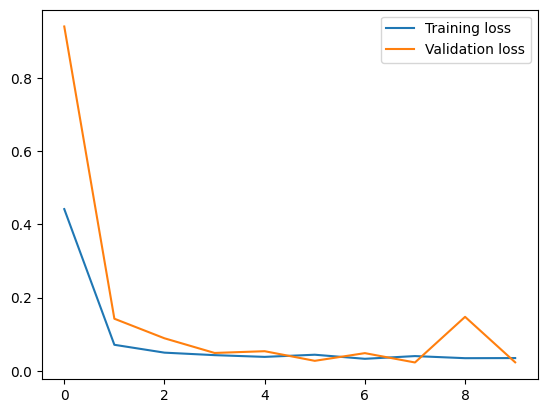

In [52]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [53]:
# ## now go ahead and forcast it
# # whe used n_future above as 1 because it was for 1 day
# # I want to forcast 14 days now
#####################################################################
# n_future = 90
# forcast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

# forcast = model.predict(trainX[-n_future:])
# # print(forcast)
##############################################################################

#Libraries that will help us extract only business days in the US.
# Otherwise our dates would be wrong when we look back (or forward).  
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_future = 90

# predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
forcast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()
print(forcast_period_dates)

#Make prediction
forcast = model.predict(trainX[-n_future:]) #shape = (n, 1) where n is the n_days_for_prediction
print(forcast)


[Timestamp('2024-10-28 00:00:00', freq='D'), Timestamp('2024-10-29 00:00:00', freq='D'), Timestamp('2024-10-30 00:00:00', freq='D'), Timestamp('2024-10-31 00:00:00', freq='D'), Timestamp('2024-11-01 00:00:00', freq='D'), Timestamp('2024-11-02 00:00:00', freq='D'), Timestamp('2024-11-03 00:00:00', freq='D'), Timestamp('2024-11-04 00:00:00', freq='D'), Timestamp('2024-11-05 00:00:00', freq='D'), Timestamp('2024-11-06 00:00:00', freq='D'), Timestamp('2024-11-07 00:00:00', freq='D'), Timestamp('2024-11-08 00:00:00', freq='D'), Timestamp('2024-11-09 00:00:00', freq='D'), Timestamp('2024-11-10 00:00:00', freq='D'), Timestamp('2024-11-11 00:00:00', freq='D'), Timestamp('2024-11-12 00:00:00', freq='D'), Timestamp('2024-11-13 00:00:00', freq='D'), Timestamp('2024-11-14 00:00:00', freq='D'), Timestamp('2024-11-15 00:00:00', freq='D'), Timestamp('2024-11-16 00:00:00', freq='D'), Timestamp('2024-11-17 00:00:00', freq='D'), Timestamp('2024-11-18 00:00:00', freq='D'), Timestamp('2024-11-19 00:00:00'

In [54]:
## now I want to bring the original number back from scaling
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform

forcast_copies = np.repeat(forcast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forcast_copies)[:,0]
print(y_pred_future)

[160.67636 161.02339 161.14586 161.10696 160.96777 160.87224 160.66815
 160.39542 160.3132  160.46419 160.5806  160.85457 161.12405 161.47855
 161.67719 161.57634 161.39072 161.40154 161.06763 160.71217 160.44437
 160.48416 161.2722  161.73247 162.14143 162.87413 163.72534 164.43022
 165.19012 165.93727 165.77423 164.92303 164.34526 163.93571 163.86143
 164.027   164.18452 164.48994 164.8396  165.28378 165.73228 166.24968
 166.6956  167.16821 167.6178  168.13486 168.5148  168.80118 169.10892
 169.5699  170.0693  169.74992 169.17043 168.34047 167.32181 166.60214
 166.20364 165.85957 165.92188 166.74638 168.15991 169.75517 171.58879
 173.66422 175.69843 177.81406 179.83914 181.63568 182.70323 183.33635
 184.00896 184.44386 184.74384 184.62941 184.69547 184.68282 184.86897
 185.17787 185.45322 186.02922 186.82584 187.40173 187.99966 188.70862
 189.25136 189.8995  188.44987 187.1632  185.67348 184.22028]


In [55]:


# Convert timestamp to date
forecast_dates = []
for time_i in forcast_period_dates:
    forecast_dates.append(time_i.date())

 ## now capture y_pred_future adn forcast_dates both in a single dataframe
   
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

# print(df_forecast)

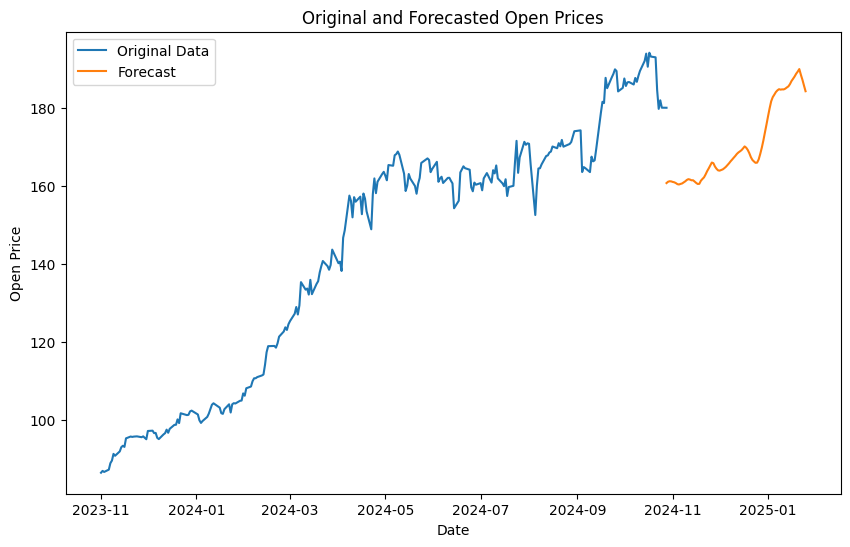

In [56]:
original = df[['Date', 'Open']].copy()
original['Date'] = pd.to_datetime(original['Date'])
original = original[original['Date'] >= '2023-11-01']

# Set up the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=original, x='Date', y='Open', label='Original Data')
sns.lineplot(data=df_forecast, x='Date', y='Open', label='Forecast')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original and Forecasted Open Prices')
plt.legend()
plt.show()